CG MSM from Qhel directly via rama-plot
====

In [1]:
import pyemma
pyemma.__version__

'2.1.1'

In [2]:
import os
%pylab inline
matplotlib.rcParams.update({'font.size': 12})

Populating the interactive namespace from numpy and matplotlib


In [3]:
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt
import msmbuilder
from msmbuilder.msm.ratematrix import ContinuousTimeMSM
import scipy
from msmtools.analysis.dense.decomposition import eigenvectors, eigenvalues
import operator

Read in the dtrajs
------

In [4]:
indir = '/data/isilon/rudzinski/cluster_tmp/AAQAA/AAQAA_hybrid_AMBER_Go/wDB-HP_inter/NC_CA/2016_10_21/epsNC-11/epsNC-11_epsdb-0.3epsNC_epshp-0.35epsNC/T-300/'

traj_dir_base = 'run_from_Qhel-'
Qhel_val = ['0.0','0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9']

Nrama = 15
GLN_rama = [4,9,14]
dtraj_rama = []
for rama in range(Nrama):
    dtraj_rama.append([])
    for i in range (len(Qhel_val)):
        for j in range(4):
            traj_dir = indir+traj_dir_base+Qhel_val[i]+'/run'+str(j+1)+'/'
            if (rama+2 in GLN_rama):
                dtraj_rama[rama].append( np.genfromtxt(traj_dir+'rama_GLN'+str(rama+2)+'.xvg')[:,0:2] )
            else:
                dtraj_rama[rama].append( np.genfromtxt(traj_dir+'rama_ALA'+str(rama+2)+'.xvg')[:,0:2] )

In [5]:
for rama in range(Nrama):
    for i in range( len(dtraj_rama[0]) ):
        dtraj_rama[rama][i][np.where(dtraj_rama[rama][i][:,1] < -125)[0],1] += 360  

In [6]:
dtraj_phi = []
for rama in range(Nrama):
    dtraj_phi.append([])
    for i in range( len(dtraj_rama[rama]) ):
        dtraj_phi[rama].append(dtraj_rama[rama][i][:,1])

**simple clustering along psi only for discretization**

In [7]:
n_clusters = 2     # number of k-means clusters

In [8]:
clustering_rama = []
for rama in range(Nrama):
    clustering_rama.append(coor.cluster_kmeans(dtraj_phi[rama],k=n_clusters,max_iter=100, tolerance=1e-12, fixed_seed=True))

26-01-17 10:33:01 pyemma.coordinates.clustering.kmeans.KmeansClustering[0] INFO     Cluster centers converged after 7 steps.
26-01-17 10:33:03 pyemma.coordinates.clustering.kmeans.KmeansClustering[1] INFO     Cluster centers converged after 6 steps.
26-01-17 10:33:05 pyemma.coordinates.clustering.kmeans.KmeansClustering[2] INFO     Cluster centers converged after 7 steps.
26-01-17 10:33:07 pyemma.coordinates.clustering.kmeans.KmeansClustering[3] INFO     Cluster centers converged after 6 steps.
26-01-17 10:33:09 pyemma.coordinates.clustering.kmeans.KmeansClustering[4] INFO     Cluster centers converged after 6 steps.
26-01-17 10:33:11 pyemma.coordinates.clustering.kmeans.KmeansClustering[5] INFO     Cluster centers converged after 9 steps.
26-01-17 10:33:13 pyemma.coordinates.clustering.kmeans.KmeansClustering[6] INFO     Cluster centers converged after 7 steps.
26-01-17 10:33:15 pyemma.coordinates.clustering.kmeans.KmeansClustering[7] INFO     Cluster centers converged after 6 steps.


[ 148.46240234    9.20454311]
[   2.677598    148.69459534]
[  -1.35588443  140.81852722]
[   2.77408338  148.85646057]
[ 146.22140503    2.08418989]
[ 141.71685791    4.24639082]
[ 148.91456604   -4.80876923]
[  -4.00003481  141.50028992]
[   1.41207981  151.50753784]
[ 146.88517761    1.43964148]
[   3.33349562  143.83721924]
[  -3.90548968  150.6275177 ]
[   0.24004877  140.09584045]
[ 145.26959229   10.58590508]
[ 148.18197632    0.44209936]


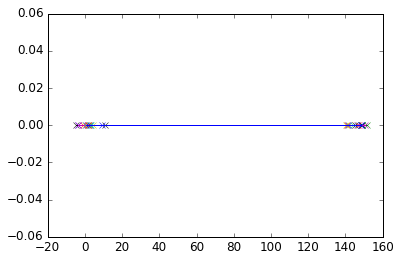

In [9]:
cc_rama = []
for rama in range(Nrama):
    cc_rama.append(clustering_rama[rama].clustercenters[:,0])
    plt.plot(cc_rama[rama],np.zeros(len(cc_rama[rama])),marker='x')
    print cc_rama[rama]

In [11]:
dtrajs_rama = []
for rama in range(Nrama):
    dtrajs_rama.append(clustering_rama[rama].dtrajs)

In [12]:
for rama in range(Nrama):
    for traj in range( len(dtraj_rama[rama]) ):
        if ( dtrajs_rama[rama][traj][np.where(dtraj_phi[rama][traj] < 0)[0][0]] != 0 ):
            dtrajs_rama[rama][traj][np.where(dtrajs_rama[rama][traj] == 0)[0]] -= 1
            dtrajs_rama[rama][traj][np.where(dtrajs_rama[rama][traj] == 1)[0]] -= 1
            dtrajs_rama[rama][traj][np.where(dtrajs_rama[rama][traj] == -1)[0]] += 2

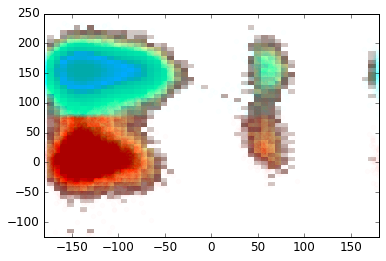

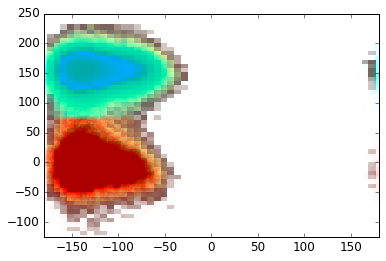

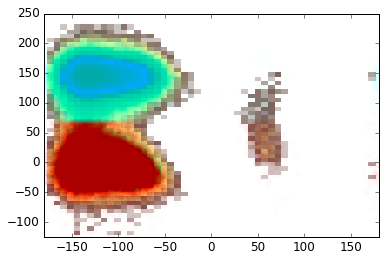

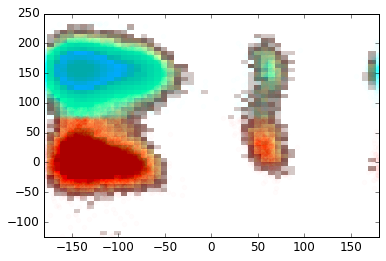

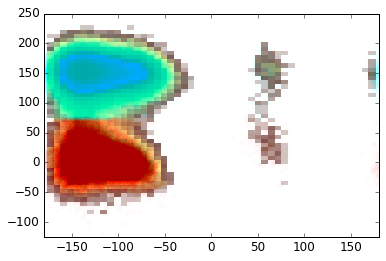

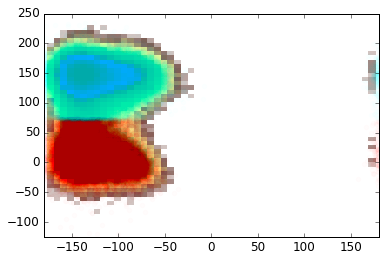

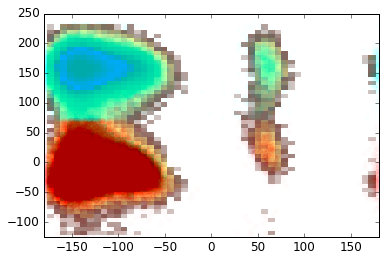

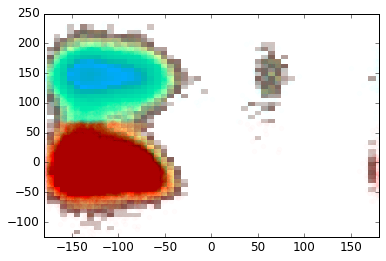

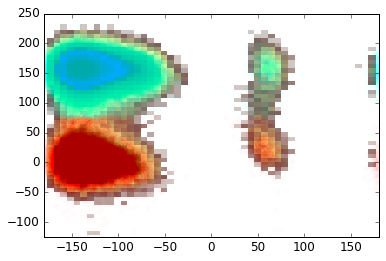

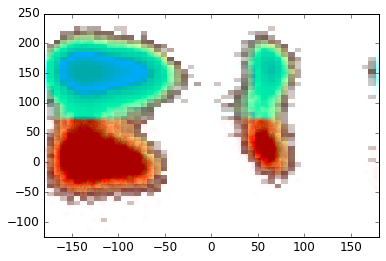

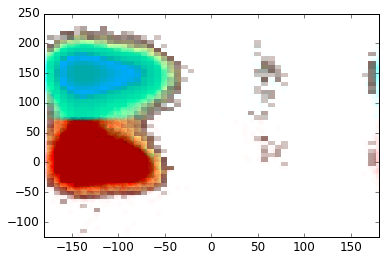

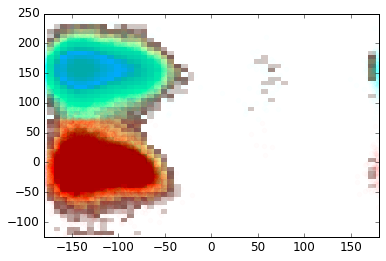

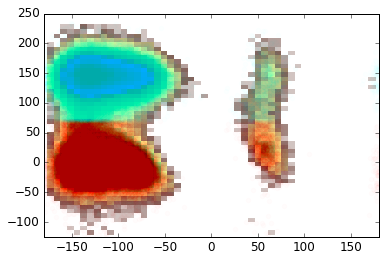

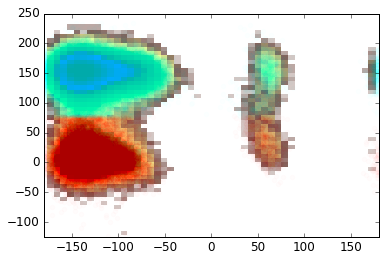

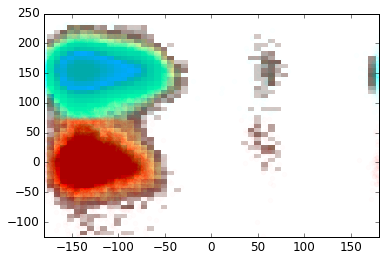

In [13]:
for rama in range(Nrama):
    H_rama, phi_edges, psi_edges = np.histogram2d(dtraj_rama[rama][0][:,0], dtraj_rama[rama][0][:,1], bins=50, range=None, normed=None, weights=None )
    phi_bins = 0.5*(phi_edges[1:] + phi_edges[:-1])
    psi_bins = 0.5*(psi_edges[1:] + psi_edges[:-1]) 

    H_rama = np.rot90(H_rama)
    H_rama = np.flipud(H_rama)
    FE_H = -np.ma.log(H_rama)
    FE_H -= np.min(FE_H)
    FE_max = np.max(FE_H)
    FE_H = FE_H.filled()
    plt.pcolormesh(phi_bins, psi_bins, FE_H, cmap='terrain', vmax=FE_max)
    plt.scatter(dtraj_rama[rama][0][np.where(dtrajs_rama[rama][0]==0),0],dtraj_rama[rama][0][np.where(dtrajs_rama[rama][0]==0),1],color='red',alpha=0.01)
    plt.scatter(dtraj_rama[rama][0][np.where(dtrajs_rama[rama][0]==1),0],dtraj_rama[rama][0][np.where(dtrajs_rama[rama][0]==1),1],color='cyan',alpha=0.01)
    plt.xlim([-180,180])
    plt.ylim([-125,250])
    plt.show()

In [33]:
dtrajs = []
for traj in range( len(dtrajs_rama[0]) ):
    tmp = dtrajs_rama[0][traj]
    for rama in range(1,len(dtrajs_rama)):
        tmp = np.vstack( (tmp,dtrajs_rama[rama][traj]) )
    tmp = tmp.T
    dtrajs.append( tmp )
    dtrajs[traj].astype('int64')

In [37]:
dtrajs[0].shape

(200001, 15)

In [38]:
dtrajs_sum = []
for i in range( len(dtrajs) ):
    dtrajs_sum.append( np.sum(dtrajs[i],axis=1) )
    dtrajs_sum[i].astype('int64')

In [39]:
# we need a single dimensional identifier of the microstate, can we cluster to automize?
n_clusters = 16
clustering = coor.cluster_regspace(dtrajs_sum,max_centers=n_clusters,dmin=0.5)
#clustering = coor.cluster_kmeans(dtrajs,k=n_clusters,max_iter=100, tolerance=1e-12, fixed_seed=True)

In [40]:
dtrajs_1D = clustering.dtrajs

In [41]:
cc = clustering.clustercenters[:]
cc

array([[ 11.],
       [ 12.],
       [ 13.],
       [ 14.],
       [ 10.],
       [  9.],
       [  8.],
       [  7.],
       [  6.],
       [  5.],
       [ 15.],
       [  4.],
       [  3.],
       [  2.],
       [  1.],
       [  0.]], dtype=float32)

In [42]:
sorted_list = sorted(cc)
cc_sorted = np.array(sorted_list)[:]
cc_sorted = cc_sorted.tolist()
for i in range(len(cc)):
    cc_sorted[i] = map(int,cc_sorted[i])
cc_sorted

[[0],
 [1],
 [2],
 [3],
 [4],
 [5],
 [6],
 [7],
 [8],
 [9],
 [10],
 [11],
 [12],
 [13],
 [14],
 [15]]

In [43]:
for traj in range(len(dtrajs_1D)):
    dtrajs_1D[traj] = cc[dtrajs_1D[traj]].astype(int)

In [46]:
# we need a single dimensional identifier of the microstate, can we cluster to automize?
# n_clusters = 2**15
# clustering = coor.cluster_regspace(dtrajs,max_centers=n_clusters,dmin=0.5)
#clustering = coor.cluster_kmeans(dtrajs,k=n_clusters,max_iter=100, tolerance=1e-12, fixed_seed=True)

# this is unnecessary and expensive for so many states, we already generated the states, just read them in
cc = np.load('/data/isilon/rudzinski/cluster_tmp/AAQAA/AAQAA_hybrid_AMBER_Go/wDB-HP_inter/NC_CA/2016_10_21/cc_full.npy')

In [47]:
#dtrajs_full_1D = clustering.dtrajs

In [55]:
# cc = clustering.clustercenters[:]
cc.shape

(32768, 15)

In [64]:
# convert the full traj to 1D
dtrajs_full_1D = []
for traj in range(len(dtrajs)):
    dtrajs_full_1D.append([])
    for fr in range(dtrajs[traj].shape[0]):
        state = np.where( np.all(dtrajs[traj][fr]==np.array(cc),axis=1) == True )[0][0]
        dtrajs_full_1D[traj].append(state)
    dtrajs_full_1D[traj] = np.array(dtrajs_full_1D[traj])

In [65]:
np.save('dtrajs_rama_2st_allres_1D', dtrajs_full_1D)
#
np.save('dtrajs_Qhel_allres_1D', dtrajs_1D)

In [66]:
np.save('traj_rama.npy', dtraj_rama)

In [71]:
mu = np.bincount(np.concatenate(dtrajs_full_1D)) / float(len(np.concatenate(dtrajs_full_1D)))

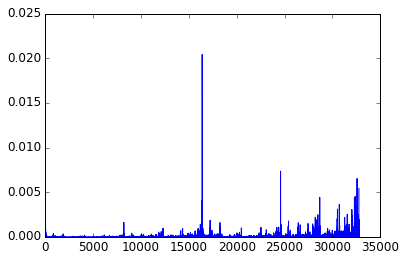

In [72]:
plt.plot(mu)

In [76]:
mu_Qhel = np.bincount(np.concatenate(dtrajs_1D[0])) / float(len(np.concatenate(dtrajs_1D[0])))

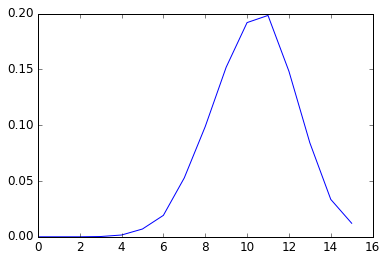

In [77]:
plt.plot(mu_Qhel)

In [78]:
mu_Qhel

array([ 0.        ,  0.        ,  0.        ,  0.000245  ,  0.00159499,
        0.00697497,  0.0192049 ,  0.05282974,  0.09874451,  0.15190924,
        0.19194404,  0.19834901,  0.14834926,  0.08420458,  0.03352483,
        0.01212494])